In [4]:
from __future__ import print_function
from __future__ import division

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_columns = 12

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy
from abupy import xrange, range

# 打开测试数据环境，与书中的例子数据一致，使用RomDataBu下的df_kl.h5数据
abupy.env.enable_example_env_ipython()


enable example env will only read RomDataBu/csv


In [5]:
print(sys.version)

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]


## 4章：pandas-learn

### 4.1.1 ： DataFrame 构建及方法

In [6]:
import pandas as pd

In [7]:
stock_day_change = np.load('../gen/stock_day_change.npy')
stock_day_change.shape

(200, 504)

In [8]:
pd.DataFrame(stock_day_change).head()
pd.DataFrame(stock_day_change).head(5)
pd.DataFrame(stock_day_change)[:5]


,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
0,0.3804,0.1226,-0.2852,-0.0089,0.4573,0.1093,-0.3681,1.3237,1.6323,0.1800,...,1.4304,0.7820,1.0432,0.3477,1.0961,-0.6955,-1.5342,0.5942,1.2468,0.3439
1,0.1338,-0.4931,1.4470,-1.0349,0.4230,0.3662,0.7446,0.5568,-0.1086,0.4740,...,-0.9448,0.6333,0.2955,-1.2758,0.2412,1.0614,-0.8178,1.3208,0.7397,1.7038
2,1.4970,1.1742,0.2613,0.7038,1.3186,-0.4790,-0.0873,-0.8022,0.0928,-0.0033,...,0.0862,0.0919,1.1406,0.4591,0.8644,1.2124,0.2709,-0.7389,-0.3335,-0.3579
3,-1.5701,0.2527,1.1458,0.2931,-1.2993,0.3162,0.7483,-2.1059,0.4344,1.6260,...,-0.7098,1.0586,0.5112,0.0777,1.3667,-0.2951,-0.9575,-0.2510,-0.1414,0.7696
4,1.3072,0.2766,-0.2871,-0.1256,-0.2172,-0.0134,0.9356,-1.3075,-0.6365,-0.4070,...,0.7130,0.2662,0.3313,-1.1977,-1.2149,-0.1997,1.0993,0.3709,-0.4096,-0.0311


### 4.1.2 索引行列序列

In [9]:
stock_symbols = ['股票' + str(x) for x in xrange(stock_day_change.shape[0])]
pd.DataFrame(stock_day_change, index=stock_symbols).head(2)

,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
股票0,0.3804,0.1226,-0.2852,-0.0089,0.4573,0.1093,-0.3681,1.3237,1.6323,0.180,...,1.4304,0.7820,1.0432,0.3477,1.0961,-0.6955,-1.5342,0.5942,1.2468,0.3439
股票1,0.1338,-0.4931,1.4470,-1.0349,0.4230,0.3662,0.7446,0.5568,-0.1086,0.474,...,-0.9448,0.6333,0.2955,-1.2758,0.2412,1.0614,-0.8178,1.3208,0.7397,1.7038


In [10]:
days = pd.date_range('2017-1-1', periods=stock_day_change.shape[1], freq='1d')
stock_symbols = ['股票' + str(x) for x in xrange(stock_day_change.shape[0])]

df = pd.DataFrame(stock_day_change, index=stock_symbols, columns=days)
df.head(2)


,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,...,2018-05-10 00:00:00,2018-05-11 00:00:00,2018-05-12 00:00:00,2018-05-13 00:00:00,2018-05-14 00:00:00,2018-05-15 00:00:00,2018-05-16 00:00:00,2018-05-17 00:00:00,2018-05-18 00:00:00,2018-05-19 00:00:00
股票0,0.3804,0.1226,-0.2852,-0.0089,0.4573,0.1093,-0.3681,1.3237,1.6323,0.180,...,1.4304,0.7820,1.0432,0.3477,1.0961,-0.6955,-1.5342,0.5942,1.2468,0.3439
股票1,0.1338,-0.4931,1.4470,-1.0349,0.4230,0.3662,0.7446,0.5568,-0.1086,0.474,...,-0.9448,0.6333,0.2955,-1.2758,0.2412,1.0614,-0.8178,1.3208,0.7397,1.7038


### 4.1.3 金融时间序列


In [11]:
df = df.T
df.head()

,股票0,股票1,股票2,股票3,股票4,股票5,股票6,股票7,股票8,股票9,...,股票190,股票191,股票192,股票193,股票194,股票195,股票196,股票197,股票198,股票199
2017-01-01,0.3804,0.1338,1.4970,-1.5701,1.3072,-0.8221,-1.8280,0.6795,0.6162,-1.4716,...,-1.9337,0.9363,0.0414,0.1169,-0.1846,1.2458,0.0452,-0.5585,-1.2133,-0.1847
2017-01-02,0.1226,-0.4931,1.1742,0.2527,0.2766,-1.1146,0.3413,-0.5707,2.1520,-0.8745,...,-0.5065,1.3101,2.7783,-0.2140,0.4578,0.4477,0.7101,-0.5875,0.0937,-0.4632
2017-01-03,-0.2852,1.4470,0.2613,1.1458,-0.2871,-0.7971,-0.2059,0.2990,-1.0013,1.7358,...,-1.1006,1.4992,-1.4178,-0.4185,1.2126,2.5001,0.8145,-0.1303,-0.3104,-0.9467
2017-01-04,-0.0089,-1.0349,0.7038,0.2931,-0.1256,1.9453,0.2045,0.4838,0.5760,0.5343,...,0.5491,0.8154,0.4971,0.3053,0.1993,1.6069,0.0845,0.4228,1.6296,1.1553
2017-01-05,0.4573,0.4230,1.3186,-1.2993,-0.2172,-1.6606,-1.0461,-1.9159,-0.9558,-1.0895,...,0.2852,1.0255,-0.6876,0.9872,-0.8155,0.7874,0.5427,-0.1573,1.0198,0.2514


In [14]:
from abupy import pd_resample
df_20 = pd_resample(df, '21D', how='mean')
df_20.head()

,股票0,股票1,股票2,股票3,股票4,股票5,股票6,股票7,股票8,股票9,...,股票190,股票191,股票192,股票193,股票194,股票195,股票196,股票197,股票198,股票199
2017-01-01,0.1013,0.3678,0.0751,-0.1024,0.1413,-0.1447,-0.0268,0.1608,0.3065,0.0767,...,0.0974,0.5264,0.1222,0.0330,-0.1458,0.1969,-0.2966,-0.4553,-0.0567,0.1840
2017-01-22,-0.0590,-0.3772,0.3770,-0.0110,0.3814,0.0161,-0.0816,0.2679,0.0769,-0.2526,...,-0.2644,0.3390,0.1679,-0.6029,0.0479,-0.3020,0.2014,0.1458,0.1965,-0.0356
2017-02-12,-0.1384,-0.2440,0.0015,0.0370,-0.1836,0.3559,-0.0196,0.0122,-0.2404,-0.0592,...,0.3232,0.2164,-0.0406,0.2500,0.1010,-0.0978,0.2082,0.0540,0.0070,0.0772
2017-03-05,0.3858,-0.1027,0.2457,-0.2191,0.0853,-0.1359,-0.0880,0.3058,0.0181,0.0195,...,0.0598,-0.1272,0.0815,-0.0631,-0.2253,0.2572,0.1409,0.3716,-0.1935,-0.2654
2017-03-26,-0.0765,-0.0083,0.0382,0.1188,0.6477,-0.2570,0.0050,0.2085,0.1097,-0.2221,...,0.0891,0.1756,0.1823,0.1668,0.1136,-0.4618,0.0316,-0.1309,-0.2588,-0.1131


### 4.1.4 Series 构建方法

In [15]:
df_stock0 = df['股票0']
print(type(df_stock0))
df_stock0.head()


<class 'pandas.core.series.Series'>


2017-01-01    0.3804
2017-01-02    0.1226
2017-01-03   -0.2852
2017-01-04   -0.0089
2017-01-05    0.4573
Freq: D, Name: 股票0, dtype: float64

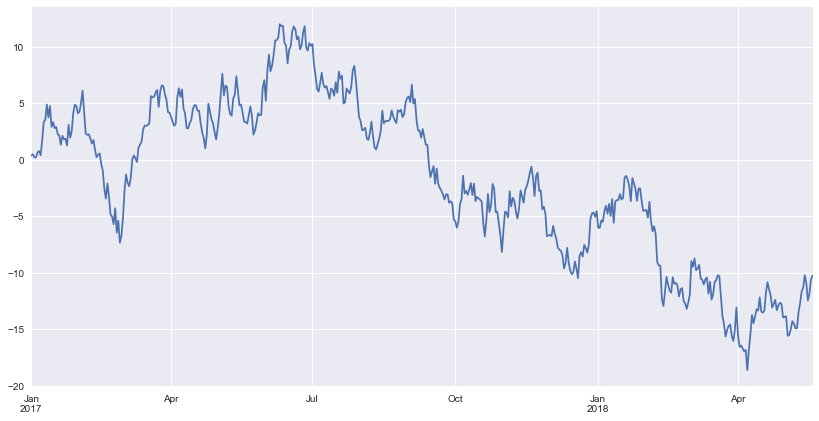

In [16]:
df_stock0.cumsum().plot()


### 4.4.5 重新采样

In [17]:
from abupy import pd_resample

df_stock0_5 = pd_resample(df_stock0.cumsum(), '5D', how='ohlc')
df_stock0_20 = pd_resample(df_stock0.cumsum(), '21D', how='ohlc')
df_stock0_5.head()

,open,high,low,close
2017-01-01,0.3804,0.6662,0.2089,0.6662
2017-01-06,0.7755,3.5434,0.4074,3.5434
2017-01-11,4.8975,4.8975,2.9178,3.3507
2017-01-16,2.8021,2.9054,1.3290,1.3290
2017-01-21,2.1272,3.1078,1.2624,3.1078


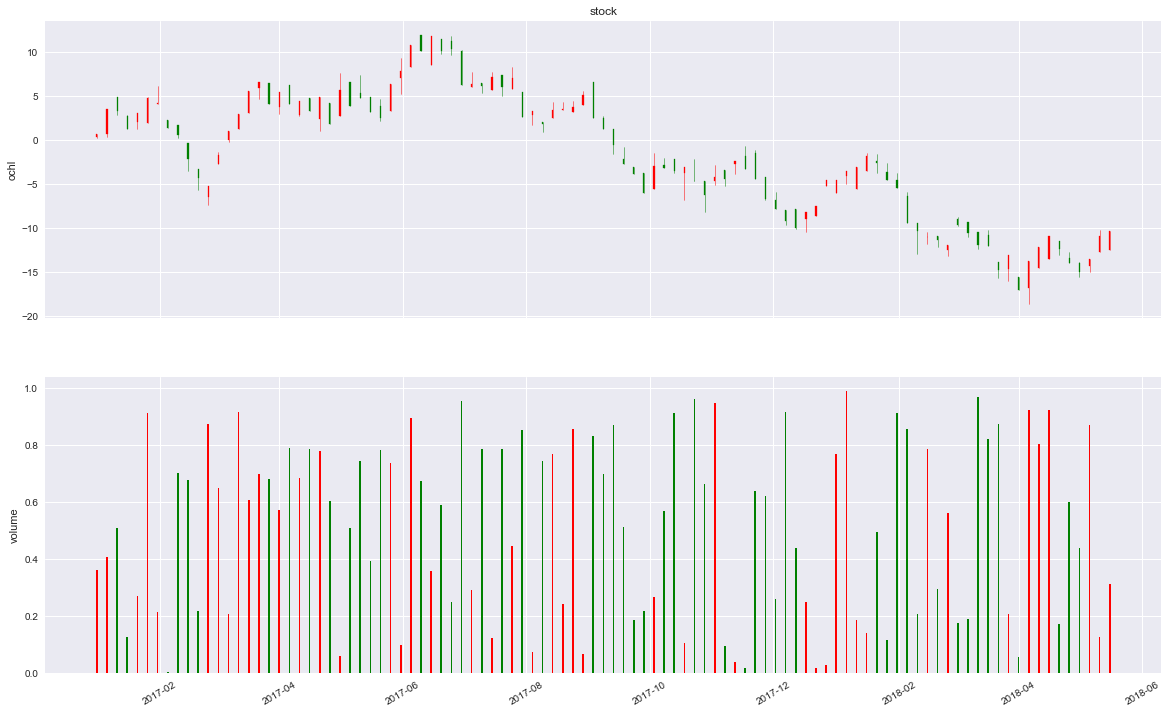

In [18]:
from abupy import ABuMarketDrawing
ABuMarketDrawing.plot_candle_stick(df_stock0_5.index, 
                                   df_stock0_5['open'].values, 
                                   df_stock0_5['high'].values, 
                                   df_stock0_5['low'].values, 
                                   df_stock0_5['close'].values, 
                                   np.random.random(len(df_stock0_5)),
                                   None, 'stock', day_sum=False, html_bk=False, save=False)

In [20]:
print(type(df_stock0_5['open'].values))
print(df_stock0_5['open'].index)
print(df_stock0_5.columns)

<class 'numpy.ndarray'>
DatetimeIndex(['2017-01-01', '2017-01-06', '2017-01-11', '2017-01-16',
               '2017-01-21', '2017-01-26', '2017-01-31', '2017-02-05',
               '2017-02-10', '2017-02-15',
               ...
               '2018-04-01', '2018-04-06', '2018-04-11', '2018-04-16',
               '2018-04-21', '2018-04-26', '2018-05-01', '2018-05-06',
               '2018-05-11', '2018-05-16'],
              dtype='datetime64[ns]', length=101, freq='5D')
Index(['open', 'high', 'low', 'close'], dtype='object')


## 4.2 基本数据分析示例

In [21]:
from abupy import ABuSymbolPd

In [22]:
tsla_df = ABuSymbolPd.make_kl_df('usTSLA', n_folds=2)
tsla_df.tail()

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2016-07-20,228.36,229.800,225.00,1.38,226.47,225.26,2568498,20160720,2,499,9.1923,8.7234
2016-07-21,220.50,227.847,219.10,-3.44,226.00,228.36,4428651,20160721,3,500,9.1711,8.7251
2016-07-22,222.27,224.500,218.88,0.80,221.99,220.50,2579692,20160722,4,501,9.1858,8.7790
2016-07-25,230.01,231.390,221.37,3.48,222.27,222.27,4490683,20160725,0,502,9.2669,8.9298
2016-07-26,225.93,228.740,225.63,-1.77,227.34,230.01,41833,20160726,1,503,9.1337,8.7541


### 4.2.1 数据整体分析

<class 'pandas.core.series.Series'>


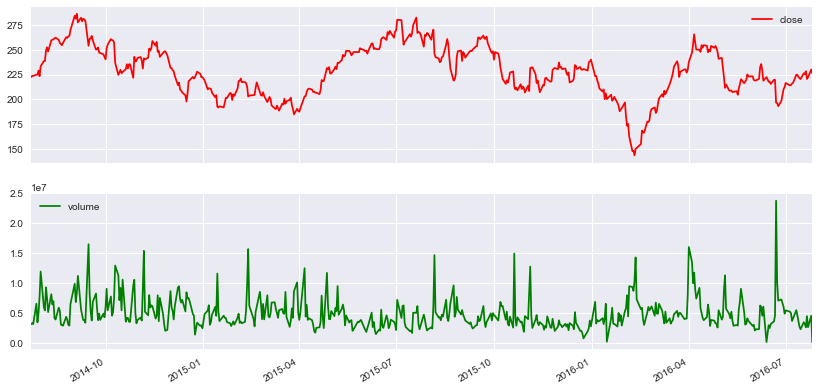

In [24]:
tsla_df[['close', 'volume']].plot(subplots = True, style=['r', 'g'], grid=True)
print(type(tsla_df['close']))

In [25]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2014-07-23 to 2016-07-26
Data columns (total 12 columns):
close        504 non-null float64
high         504 non-null float64
low          504 non-null float64
p_change     504 non-null float64
open         504 non-null float64
pre_close    504 non-null float64
volume       504 non-null int64
date         504 non-null int64
date_week    504 non-null int64
key          504 non-null int64
atr21        504 non-null float64
atr14        504 non-null float64
dtypes: float64(8), int64(4)
memory usage: 51.2 KB


In [26]:
tsla_df.describe()

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
count,504.0000,504.0000,504.0000,504.0000,504.0000,504.0000,5.0400e+02,5.0400e+02,504.0000,504.0000,504.0000,504.0000
mean,228.4653,232.1352,224.5626,0.0375,228.4258,228.4587,4.9038e+06,2.0151e+07,2.0159,251.5000,10.2617,10.2592
std,25.4947,25.2726,25.6123,2.6076,25.5300,25.5050,2.6580e+06,6.8708e+03,1.3986,145.6365,1.5960,1.8714
min,143.6700,154.9700,141.0500,-10.4500,142.3200,143.6700,4.1833e+04,2.0141e+07,0.0000,0.0000,6.7806,6.2251
25%,210.3100,214.5175,207.0700,-1.2525,210.7175,210.3100,3.1852e+06,2.0150e+07,1.0000,125.7500,9.1850,9.0220
50%,227.6150,231.8250,223.4300,0.0650,227.8250,227.6150,4.2418e+06,2.0151e+07,2.0000,251.5000,10.0495,10.0609
75%,248.4800,251.9100,245.5575,1.3700,248.8525,248.4800,5.8039e+06,2.0160e+07,3.0000,377.2500,11.4082,11.3879
max,286.0400,291.4200,280.4000,11.1700,287.6700,286.0400,2.3742e+07,2.0161e+07,4.0000,503.0000,14.9311,16.6603


### 4.2.2 索引选取和切片选择

In [27]:
tsla_df.loc['2014-07-23':'2014-07-31', 'open']

2014-07-23    220.01
2014-07-24    223.25
2014-07-25    222.72
2014-07-28    224.25
2014-07-29    226.61
2014-07-30    221.92
2014-07-31    229.26
Name: open, dtype: float64

In [28]:
tsla_df.loc['2014-07-23':'2014-07-31', ['open', 'close']]

,open,close
2014-07-23,220.01,222.49
2014-07-24,223.25,223.54
2014-07-25,222.72,223.57
2014-07-28,224.25,224.82
2014-07-29,226.61,225.01
2014-07-30,221.92,228.92
2014-07-31,229.26,223.30


In [29]:
tsla_df.iloc[0:5, 0:5]

,close,high,low,p_change,open
2014-07-23,222.49,224.75,219.43,1.33,220.01
2014-07-24,223.54,225.10,220.80,0.47,223.25
2014-07-25,223.57,226.97,221.75,0.01,222.72
2014-07-28,224.82,232.00,221.40,0.56,224.25
2014-07-29,225.01,228.30,224.86,0.08,226.61


In [30]:
tsla_df.open[0:3]

2014-07-23    220.01
2014-07-24    223.25
2014-07-25    222.72
Name: open, dtype: float64

### 4.2.3 逻辑条件进行数据筛选

In [34]:
tsla_df[np.abs(tsla_df.p_change) > 8] 

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2014-09-15,253.86,274.40,249.13,-9.08,274.370,279.20,16464949,20140915,0,37,9.9963,10.4530
2014-10-28,242.77,244.60,228.25,9.52,229.600,221.67,10516300,20141028,1,68,11.2590,11.4392
2015-08-06,246.13,255.00,236.12,-8.88,249.540,270.13,14623754,20150806,3,261,10.7972,11.5946
2015-08-27,242.99,244.75,230.81,8.07,231.000,224.84,7655959,20150827,3,276,14.3472,15.8950
2015-11-04,231.63,232.74,225.20,11.17,227.000,208.35,12726366,20151104,2,324,11.1504,10.8725
2016-02-08,147.99,157.15,146.00,-8.99,157.105,162.61,9312988,20160208,0,388,12.3292,13.3551
2016-02-17,168.68,169.34,156.68,8.71,159.000,155.17,5825159,20160217,2,394,13.2054,14.2134
2016-06-22,196.66,205.95,195.75,-10.45,199.470,219.61,23742414,20160622,2,481,9.8900,9.8683


In [35]:
tsla_df[(np.abs(tsla_df.p_change) > 8) & (tsla_df.volume > 2.5 * tsla_df.volume.mean())]

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2014-09-15,253.86,274.40,249.13,-9.08,274.37,279.20,16464949,20140915,0,37,9.9963,10.4530
2015-08-06,246.13,255.00,236.12,-8.88,249.54,270.13,14623754,20150806,3,261,10.7972,11.5946
2015-11-04,231.63,232.74,225.20,11.17,227.00,208.35,12726366,20151104,2,324,11.1504,10.8725
2016-06-22,196.66,205.95,195.75,-10.45,199.47,219.61,23742414,20160622,2,481,9.8900,9.8683


In [43]:
# 成交量是前一天的3倍的交易日
tsla_df['pre_volume'] = tsla_df['volume'].shift(1)
tsla_df[['pre_volume', 'volume']].tail()
filtered_df = tsla_df[tsla_df.volume >= 3 * tsla_df['pre_volume']]
print(filtered_df)

             close    high     low  p_change     open  pre_close    volume  \
2014-09-15  253.86  274.40  249.13     -9.08  274.370    279.200  16464949   
2014-12-01  231.64  242.47  229.01     -5.27  241.160    244.520   8619351   
2015-04-27  231.55  238.75  222.00      6.01  222.630    218.425  11672627   
2015-07-02  280.02  282.45  273.31      4.04  280.195    269.150   7163930   
2015-07-17  274.66  275.54  268.25      2.99  272.500    266.680   5004099   
2015-10-20  213.03  228.60  202.00     -6.61  227.720    228.100  14900047   
2016-01-19  204.72  210.47  200.78      2.19  208.710    200.330   4038676   
2016-06-15  217.70  221.90  215.13     -2.14  216.950    222.460   2908522   
2016-06-22  196.66  205.95  195.75    -10.45  199.470    219.610  23742414   

                date  date_week  key    atr21    atr14  pre_volume  
2014-09-15  20140915          0   37   9.9963  10.4530   3328302.0  
2014-12-01  20141201          0   91   9.9307   9.6334   2119688.0  
2015-04-27  